In [1]:
from __future__ import absolute_import, print_function, division

# Putting what you've learnt together:

### Building an mini-ANTARES (ish) Pipeline for Data Management and Discovery
========

#### Version 0.1

***
By AA Miller 2017 Apr 10

Edited G. Narayan 2017 Apr 26

As we just saw LSST will produce an unprecedented volume of time-domain information for the astronomical sky. $>37$ trillion individual photometric measurements will be recorded. While the vast, vast majority of these measurements will simply confirm the status quo, some will represent rarities that have never been seen before (e.g., LSST may be the first telescope to discover the electromagnetic counterpart to a LIGO graviational wave event), which the community will need to know about in ~real time. 

Storing, filtering, and serving this data is going to be a huge <del>nightmare</del> challenge. ANTARES is one proposed solution to this challenge. In this exercise you will build a miniature version of ANTARES, which will require the application of several of the lessons from earlier this week. 


Many of the difficult, and essential, steps necessary for ANTARES will be skipped here as they are too time consuming or beyond the scope of what we have previously covered. We will point out these challenges are we come across them.

---

## 0) There is a README.MD file along with this notebook.

Do it!

---

If everything worked OK up to this point, congratulations! You now have access to a (mini) parallel computing environment of your own.

In [2]:
# first we need to construct a client that will interface with our cluster
from ipyparallel import Client, require
worker = Client()

In [3]:
# once we create a client, we can decide how to allocate tasks across the cluster
# we've got however many 'engines' you started in the cluster
# lets just use all of them

lview = worker[:]

# now if you want to import packages, you can import them across all the 'engines'
with lview.sync_imports():    
    import numpy as np
    import scipy.stats as spstat
    import pandas as pd
    import os

# there's not much point in creating plots on the engines - we want to actually see them presumably
import matplotlib.pyplot as plt
%matplotlib notebook

# If everything has worked so far, you should see a list of worker IDs, and a corresponding list of process IDs.
# You can verify it with a `ps`
ar = lview.apply_async(os.getpid)
print("Engine ID:PID mapping: ", ar.get_dict())

importing numpy on engine(s)
importing scipy.stats on engine(s)
importing pandas on engine(s)
importing os on engine(s)
Engine ID:PID mapping:  {0: 91176, 1: 91177, 2: 91178, 3: 91179}


## Problem 1) Light Curve Data

We begin by ignoring the streaming aspect of the problem and instead we will work with full light curves. One way of thinking about this is that we're working in a mode where LSST has been imaging this field at least a few times, so we have some historical data on it, which we've already associated with an alert from LSST.

The collection of light curves has been curated by Gautham, and like LSST, it features objects of different types covering a large range in brightness and observations in multiple filters taken at different cadences.

As the focus of this exercise is the construction of a data management pipeline, we have already created a Python `class` to read in the data and store light curves as objects. The data are stored in flat text files with the following format:

|t               |pb   |flux        |dflux       |
|:--------------:|:---:|:----------:|-----------:|
|   56254.160000 |  i  |   6.530000 |   4.920000 |
|   56254.172000 |  z  |   4.113000 |   4.018000 |
|   56258.125000 |  g  |   5.077000 |  10.620000 |
|   56258.141000 |  r  |   6.963000 |   5.060000 |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |

and names `FAKE0XX.dat` where the `XX` is a running index from `01` to `99`. 

**Problem 1a**

Read in the data for the first light curve file and plot the $g'$ light curve for that source.

*Hint* - Use `pandas` or `numpy`.

<IPython.core.display.Javascript object>


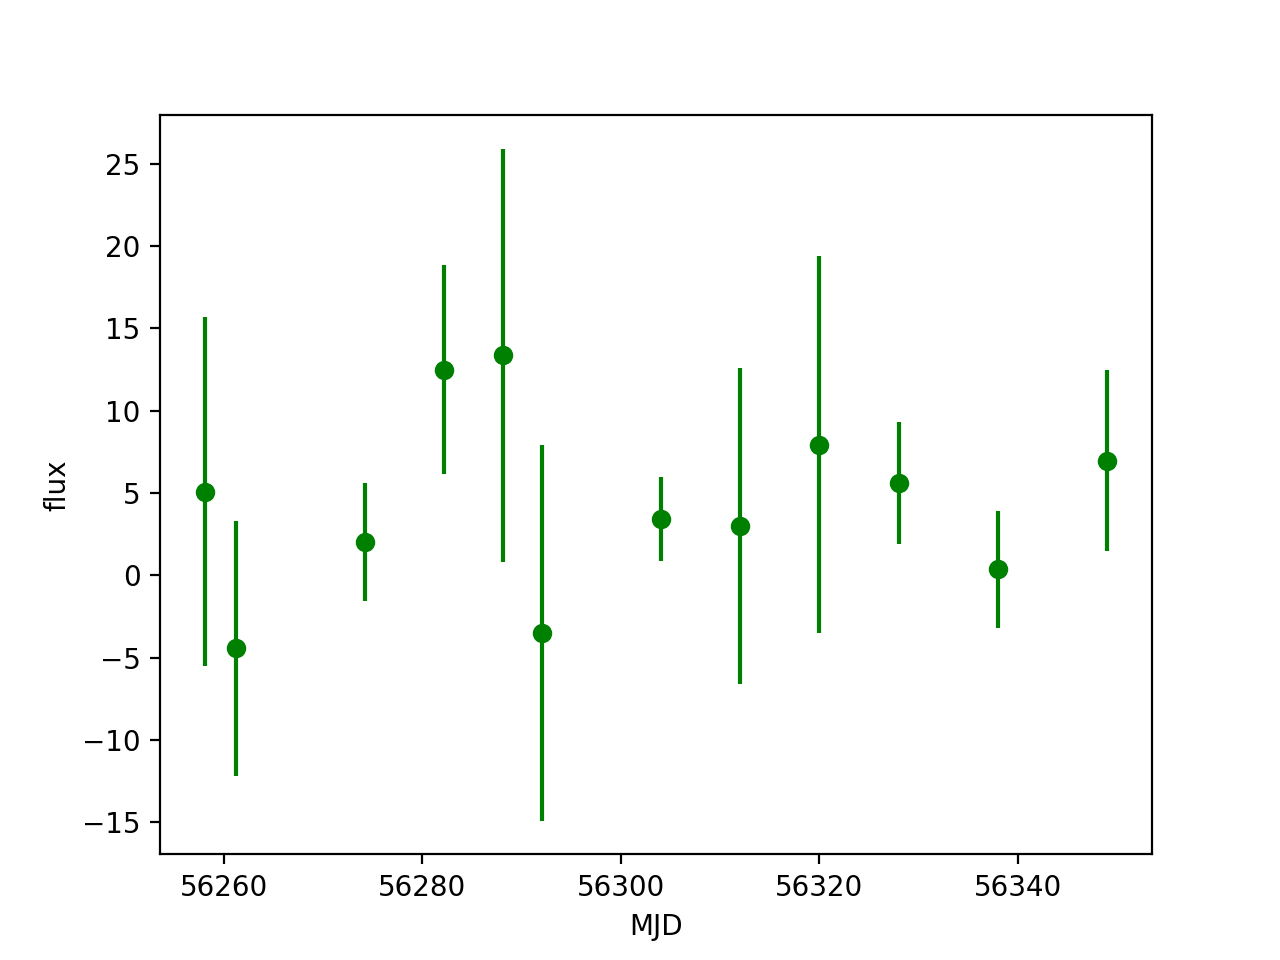

In [4]:
# execute this cell

lc = pd.read_csv('training_set_for_LSST_DSFP/FAKE001.dat', delim_whitespace=True, comment = '#')

plt.errorbar(np.array(lc['t'].ix[lc['pb'] == 'g']), 
             np.array(lc['flux'].ix[lc['pb'] == 'g']), 
             np.array(lc['dflux'].ix[lc['pb'] == 'g']), fmt = 'o', color = 'green')
plt.xlabel('MJD')
plt.ylabel('flux')

As we have many light curve files (in principle as many as 37 billion...), we will define a light curve class to ease our handling of the data.

** Problem 1b** 

Fix the `lc` class definition below.

*Hint* - the only purpose of this problem is to make sure you actually read each line of code below, it is not intended to be difficult.

In [5]:
class ANTARESlc():
    '''Light curve object for NOAO formatted data'''
    
    def __init__(self, filename):
        '''Read in light curve data'''
        DFlc = pd.read_csv(filename, delim_whitespace=True, comment = '#')
        self.DFlc = DFlc
        self.filename = filename
        
    def plot_multicolor_lc(self):
        '''Plot the 4 band light curve'''
        fig, ax = plt.subplots()
        g = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'g'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'g'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g'],
                     fmt = 'o', color = '#78A5A3', label = r"$g'$")
        r = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'r'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'r'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r'],
                     fmt = 'o', color = '#CE5A57', label = r"$r'$")
        i = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'i'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'i'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i'],
                     fmt = 'o', color = '#E1B16A', label = r"$i'$")
        z = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'z'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'z'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z'],
                     fmt = 'o', color = '#444C5C', label = r"$z'$")
        ax.legend(fancybox = True)
        ax.set_xlabel(r"$\mathrm{MJD}$")
        ax.set_ylabel(r"$\mathrm{flux}$")

**Problem 1c**

Confirm the corrections made in **1b** by plotting the multiband light curve for the source `FAKE010`.

<IPython.core.display.Javascript object>


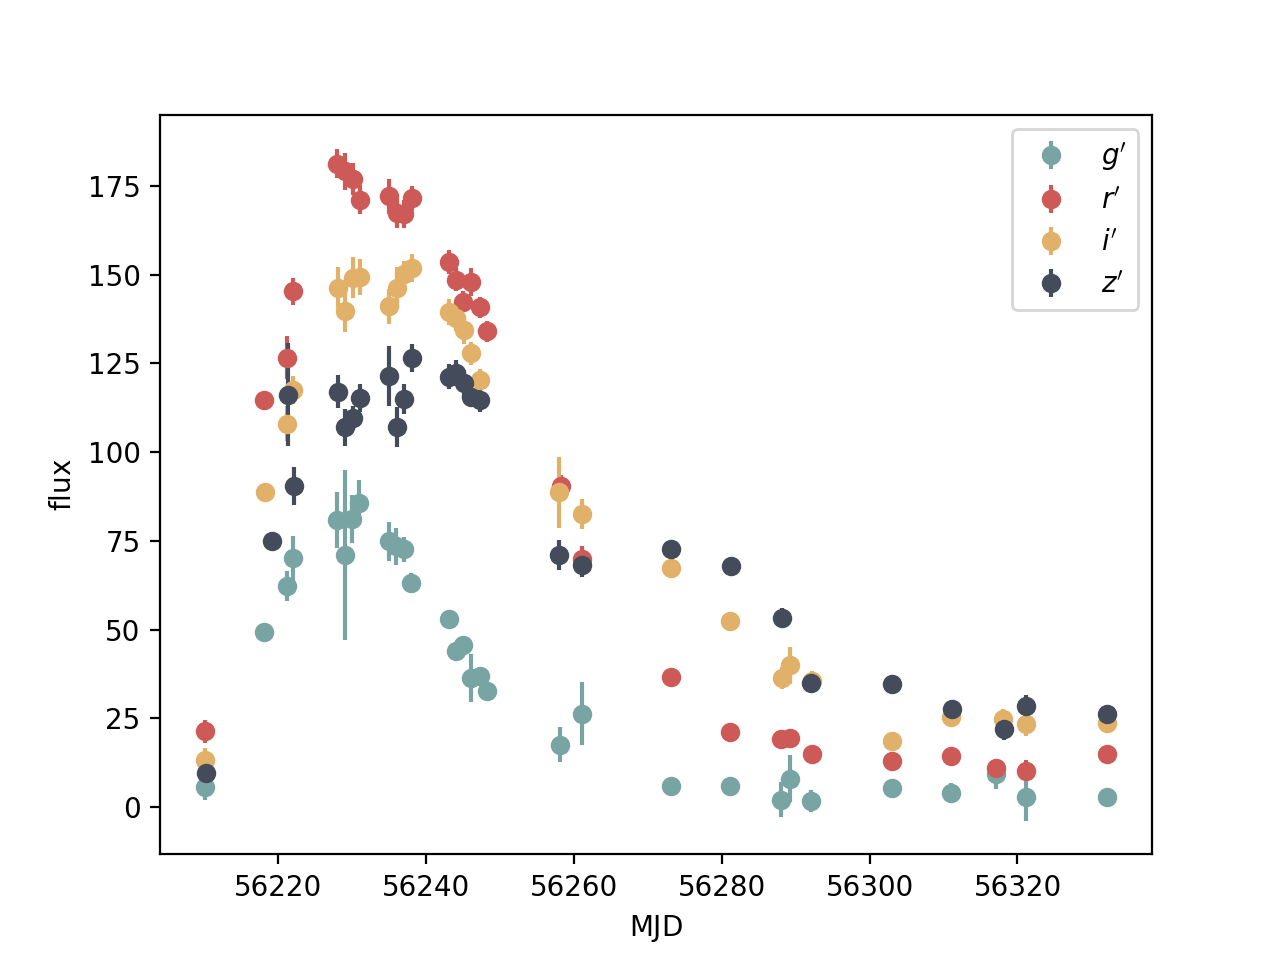

In [6]:
lc = ANTARESlc('training_set_for_LSST_DSFP/FAKE010.dat')

lc.plot_multicolor_lc()

One thing that we brushed over previously is that the brightness measurements have units of flux, rather than the traditional use of magnitudes. The reason for this is that LSST will measure flux variations via image differencing, which will for some sources in some filters result in a measurement of *negative flux*. (You may have already noticed this in **1a**.) Statistically there is nothing wrong with such a measurement, but it is impossible to convert a negative flux into a magnitude. Thus we will use flux measurements throughout this exercise. 

[Aside - if you are bored during the next break, I'd be happy to rant about why we should have ditched the magnitude system years ago.]

Using flux measurements will allow us to make unbiased measurements of the statistical distributions of the variations of the sources we care about. 

**Problem 1d**

What is `FAKE010` the source that is plotted above?

*Hint 1* - "That's no moon!".

*Hint 2* - ask Szymon or Tomas... 

**Solution 1d**

`FAKE010` is a transient, as can be seen by the rapid rise followed by a gradual decline in the light curve. In this particular case, we can further guess that `FAKE010` is a Type Ia supernova due to the secondary maxima in the $i'$ and $z'$ light curves. These secondary peaks are not present in any other known type of transient.

**Problem 1e**

To get a better sense of the data, plot the multiband light curves for sources `FAKE060` and `FAKE073`.

<IPython.core.display.Javascript object>


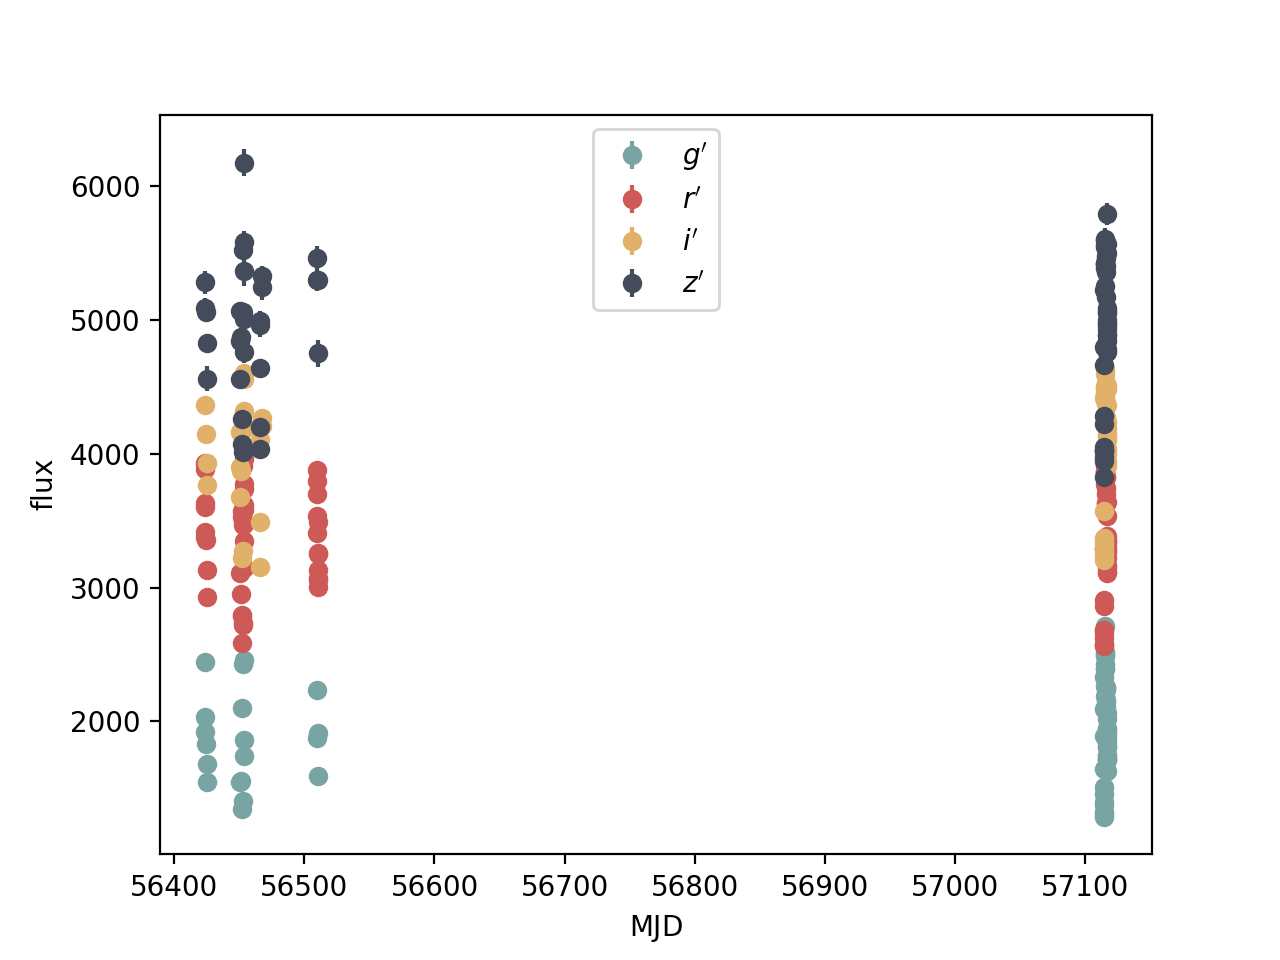

<IPython.core.display.Javascript object>


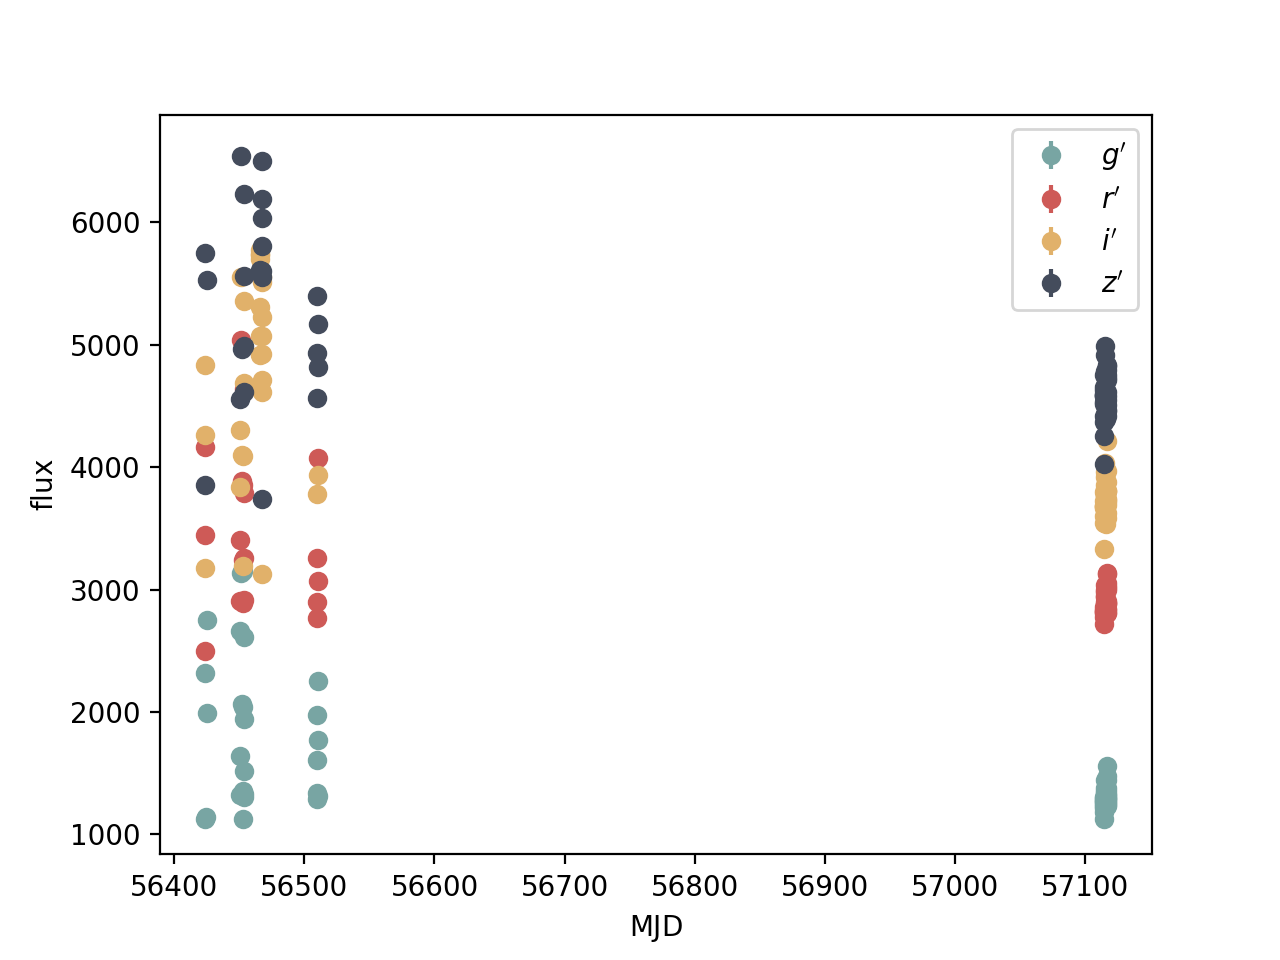

In [7]:
lc59 = ANTARESlc("training_set_for_LSST_DSFP/FAKE060.dat")
lc59.plot_multicolor_lc()

lc60 = ANTARESlc("training_set_for_LSST_DSFP/FAKE073.dat")
lc60.plot_multicolor_lc()

## Problem 2) Data Preparation

While we could create a database table that includes every single photometric measurement made by LSST, this ~37 trillion row db would be enormous without providing a lot of added value beyond the raw flux measurements [while this table is necessary, alternative tables may provide more useful]. Furthermore, extracting individual light curves from such a database will be slow. Instead, we are going to develop summary statistics for every source which will make it easier to select individual sources and develop classifiers to identify objects of interest.  

Below we will redefine the `ANTARESlc` class to include additional methods so we can (eventually) store summary statistics in a database table. In the interest of time, we limit the summary statistics to a relatively small list all of which have been shown to be useful for classification (see [Richards et al. 2011](http://iopscience.iop.org/article/10.1088/0004-637X/733/1/10/meta) for further details). The statistics that we include (for now) are: 

1. `Std` -- the standard deviation of the flux measurements 
2. `Amp` -- the amplitude of flux deviations
3. `MAD` -- the median absolute deviation of the flux measurements
4. `beyond1std` -- the fraction of flux measurements beyond 1 standard deviation
5. the mean $g' - r'$, $r' - i'$, and $i' - z'$ color


**Not actually a Problem 2a**

Complete the mean color module in the `ANTARESlc` class. Feel free to use the other modules as a template for your work. 

*Hint*/*food for thought* - if a source is observed in different filters but the observations are not simultaneous (or quasi-simultaneous), what is the meaning of a "mean color"?

*Solution to food for thought* - in this case we simply want you to take the mean flux in each filter and create a statistic that is $-2.5 \log \frac{\langle f_X \rangle}{\langle f_{Y} \rangle}$, where ${\langle f_{Y} \rangle}$ is the mean flux in band $Y$, while $\langle f_X \rangle$ is the mean flux in band $X$, which can be $g', r', i', z'$. Note that our use of image-difference flux measurements, which can be negative, means you'll need to add some form a case excpetion if $\langle f_X \rangle$ or $\langle f_Y \rangle$ is negative. In these cases set the color to -999.

In [8]:
# Normally, we'd actually make you complete 2a
# but the focus here is to see how the pieces fit together
# so instead execute this

class ANTARESlc():
    '''Light curve object for NOAO formatted data'''
    
    def __init__(self, filename):
        '''Read in light curve data'''
        DFlc = pd.read_csv(filename, delim_whitespace=True, comment = '#')
        self.DFlc = DFlc
        self.filename = filename
        self.filter_flux()
        
    def plot_multicolor_lc(self):
        '''Plot the 4 band light curve'''
        fig, ax = plt.subplots()
        g = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'g'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'g'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g'],
                     fmt = 'o', color = '#78A5A3', label = r"$g'$")
        r = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'r'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'r'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r'],
                     fmt = 'o', color = '#CE5A57', label = r"$r'$")
        i = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'i'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'i'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i'],
                     fmt = 'o', color = '#E1B16A', label = r"$i'$")
        z = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'z'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'z'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z'],
                     fmt = 'o', color = '#444C5C', label = r"$z'$")
        ax.legend(fancybox = True)
        ax.set_xlabel(r"$\mathrm{MJD}$")
        ax.set_ylabel(r"$\mathrm{flux}$")
        
    def filter_flux(self):
        '''Store individual passband fluxes as object attributes'''
        
        self.gtime = self.DFlc['t'].ix[self.DFlc['pb'] == 'g']
        self.gFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'g']
        self.gFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g']

        self.rtime = self.DFlc['t'].ix[self.DFlc['pb'] == 'r']
        self.rFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'r']
        self.rFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r']

        self.itime = self.DFlc['t'].ix[self.DFlc['pb'] == 'i']
        self.iFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'i']
        self.iFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i']

        self.ztime = self.DFlc['t'].ix[self.DFlc['pb'] == 'z']
        self.zFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'z']
        self.zFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z']

    def weighted_mean_flux(self):
        '''Measure (SNR weighted) mean flux in griz'''
            
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        self.gMean = weighted_mean(self.gFlux, self.gFluxUnc)
        self.rMean = weighted_mean(self.rFlux, self.rFluxUnc)
        self.iMean = weighted_mean(self.iFlux, self.iFluxUnc)
        self.zMean = weighted_mean(self.zFlux, self.zFluxUnc)

    def normalized_flux_std(self):
        '''Measure standard deviation of flux in griz'''

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1) 
        
        self.gStd = normalized_flux_std(self.gFlux, self.gMean) if len(self.gFlux) > 1 else -999
        self.rStd = normalized_flux_std(self.rFlux, self.rMean) if len(self.iFlux) > 1 else -999
        self.iStd = normalized_flux_std(self.iFlux, self.iMean) if len(self.rFlux) > 1 else -999
        self.zStd = normalized_flux_std(self.zFlux, self.zMean) if len(self.zFlux) > 1 else -999

    def normalized_amplitude(self):
        '''Measure the normalized amplitude of variations in griz'''

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()

        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        
        self.gAmp = normalized_amplitude(self.gFlux, self.gMean)
        self.rAmp = normalized_amplitude(self.rFlux, self.rMean)
        self.iAmp = normalized_amplitude(self.iFlux, self.iMean)
        self.zAmp = normalized_amplitude(self.zFlux, self.zMean)

    def normalized_MAD(self):
        '''Measure normalized Median Absolute Deviation (MAD) in griz'''

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()

        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        
        self.gMAD = normalized_MAD(self.gFlux, self.gMean)
        self.rMAD = normalized_MAD(self.rFlux, self.rMean)
        self.iMAD = normalized_MAD(self.iFlux, self.iMean)
        self.zMAD = normalized_MAD(self.zFlux, self.zMean)

    def normalized_beyond_1std(self):
        '''Measure fraction of flux measurements beyond 1 std'''

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        self.gBeyond = beyond_1std(self.gFlux, self.gMean)
        self.rBeyond = beyond_1std(self.rFlux, self.rMean)
        self.iBeyond = beyond_1std(self.iFlux, self.iMean)
        self.zBeyond = beyond_1std(self.zFlux, self.zMean)
    
    def skew(self):
        '''Measure the skew of the flux measurements'''
            
        skew = lambda flux: spstat.skew(flux) 
        
        self.gSkew = skew(self.gFlux)
        self.rSkew = skew(self.rFlux)
        self.iSkew = skew(self.iFlux)
        self.zSkew = skew(self.zFlux)
        
    def mean_colors(self):
        '''Measure the mean g-r, g-i, and g-z colors'''

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        self.gMinusR = -2.5*np.log10(self.gMean/self.rMean) if self.gMean> 0 and self.rMean > 0 else -999
        self.rMinusI = -2.5*np.log10(self.rMean/self.iMean) if self.rMean> 0 and self.iMean > 0 else -999
        self.iMinusZ = -2.5*np.log10(self.iMean/self.zMean) if self.iMean> 0 and self.zMean > 0 else -999

**Problem 2b**

Confirm your solution to **2a** by measuring the mean colors of source `FAKE010`. Does your measurement make sense given the plot you made in **1c**?

In [9]:
lc = ANTARESlc('training_set_for_LSST_DSFP/FAKE010.dat')

lc.mean_colors()

print("The g'-r', r'-i', and 'i-z' colors are:\
    {:.3f}, {:.3f}, and {:.3f}, respectively.". format(lc.gMinusR, lc.rMinusI, lc.iMinusZ))

The g'-r', r'-i', and 'i-z' colors are:    1.048, -0.191, and -0.193, respectively.


## Problem 3) Store the sources in a database

Building (and managing) a database from scratch is a challenging task. For (very) small projects one solution to this problem is to use [`SQLite`](http://sqlite.org/), which is a self-contained, publicly available SQL engine. One of the primary advantages of `SQLite` is that no server setup is required, unlike other popular tools such as postgres and MySQL. In fact, `SQLite` is already integrated with python so everything we want to do (create database, add tables, load data, write queries, etc.) can be done within Python.

Without diving too deep into the details, here are situations where `SQLite` has advantages and disadvantages [according to their own documentation](http://sqlite.org/whentouse.html):

*Advantages*

1. Situations where expert human support is not needed
2. For basic data analysis (`SQLite` is easy to install and manage for new projects)
3. Education and training

*Disadvantages*

1. Client/Server applications (`SQLite` does not behave well if multiple systems need to access db at the same time)
2. Very large data sets (`SQLite` stores entire db in a single disk file, other solutions can store data across multiple files/volumes)
3. High concurrency (Only 1 writer allowed at a time for `SQLite`)

From the (limited) lists above, you can see that while `SQLite` is perfect for our application right now, if you were building an actual ANTARES-like system a more sophisticated database solution would be required.  

**Problem 3a**

Import sqlite3 into the notebook. 

*Hint* - if this doesn't work, you may need to `conda install sqlite3` or `pip install sqlite3`.

In [10]:
import sqlite3

Following the `sqlite3` import, we must first connect to the database. If we attempt a connection to a database that does not exist, then a new database is created. Here we will create a new database file, called `miniANTARES.db`.

In [11]:
conn = sqlite3.connect("miniANTARES.db")

We now have a database connection object, `conn`. To interact with the database (create tables, load data, write queries) we need a cursor object.

In [12]:
cur = conn.cursor()

Now that we have a cursor object, we can populate the database. As an example we will start by creating a table to hold all the raw photometry (though ultimately we will not use this table for analysis).

*Note* - there are many cursor methods capable of interacting with the database. The most common, [`execute`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.execute), takes a single `SQL` command as its argument and executes that command. Other useful methods include [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany), which is useful for inserting data into the database, and [`executescript`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executescript), which take an `SQL` script as its argument and executes the script.

In many cases, as below, it will be useful to use triple quotes in order to improve the legibility of your code.

In [13]:
cur.execute("""drop table if exists rawPhot""") # drop the table if is already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

Let's unpack everything that happened in these two commands. First - if the table `rawPhot` already exists, we drop it to start over from scratch. (this is useful here, but should not be adopted as general practice)

Second - we create the new table `rawPhot`, which has 6 columns: `id` - a running index for every row in the table, `objId` - an ID to identify which source the row belongs to, `t` - the time of observation in MJD, `pb` - the passband of the observation, `flux` the observation flux, and `dflux` the uncertainty on the flux measurement. In addition to naming the columns, we also must declare their type. We have declared `id` as the primary key, which means this value will automatically be assigned and incremented for all data inserted into the database. We have also declared `pb` as a variable character of length 1, which is more useful and restrictive than simply declaring `pb` as `text`, which allows any freeform string.

Now we need to insert the raw flux measurements into the database. To do so, we will use the `ANTARESlc` class that we created earlier. As an initial example, we will insert the first 3 observations from the source `FAKE010`.

In [14]:
filename = "training_set_for_LSST_DSFP/FAKE001.dat"
lc = ANTARESlc(filename)

objId = int(filename.split('FAKE')[1].split(".dat")[0])

cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[0])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[1])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[2])))

There are two things to highlight above: (1) we do not specify an id for the data as this is automatically generated, and (2) the data insertion happens via a tuple. In this case, we are taking advantage of the fact that a Python tuple is can be concatenated:

    (objId,) + tuple(lc10.DFlc.ix[0]))
    
While the above example demonstrates the insertion of a single row to the database, it is far more efficient to bulk load the data. To do so we will delete, i.e. `DROP`, the rawPhot table and use some `pandas` manipulation to load the contents of an entire file at once via [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany).

In [15]:
cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

# next 3 lines are already in name space; repeated for clarity
filename = "training_set_for_LSST_DSFP/FAKE001.dat"
lc = ANTARESlc(filename)
objId = int(filename.split('FAKE')[1].split(".dat")[0])

data = [(objId,) + tuple(x) for x in lc.DFlc.values] # array of tuples

cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)


Load all of the raw photometric observations into the `rawPhot` table in the database.
Normally, you'd load these files one by one in serial, looping over each file. This is what happens in `miniAntares_serial.ipynb`. Instead, we're going to use our cluster to parallelize this operation.

**Problem 3b**
First, build a list of filenames:  

*Hint* - you can use [`glob`](https://docs.python.org/3/library/glob.html) to select all of the files being loaded.

*Hint 2* - you have already loaded the data from `FAKE001` into the table.

In [16]:
# build your list of filenames here
import glob
filenames = glob.glob("training_set_for_LSST_DSFP/FAKE*.dat")

In [17]:
# execute this
@require(ANTARESlc, 'pandas as pd')
def load_data(filename):
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    data = [(objId,) + tuple(x) for x in lc.DFlc.values] # array of tuples
    return data

Now, figure out how to use the `DirectView` access to the cluster to map this function on to all the filenames, and get the results. Examine a few of them.

In [18]:
result = lview.map(load_data, filenames[1:])
all_data = result.get()

And now that you have results, load them in the database as before.

In [19]:
for data in all_data: 
    cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 3c**

To ensure the data have been loaded properly, select the $r'$ light curve for source `FAKE010` from the `rawPhot` table and plot the results. Does it match the plot from **1c**?

<IPython.core.display.Javascript object>


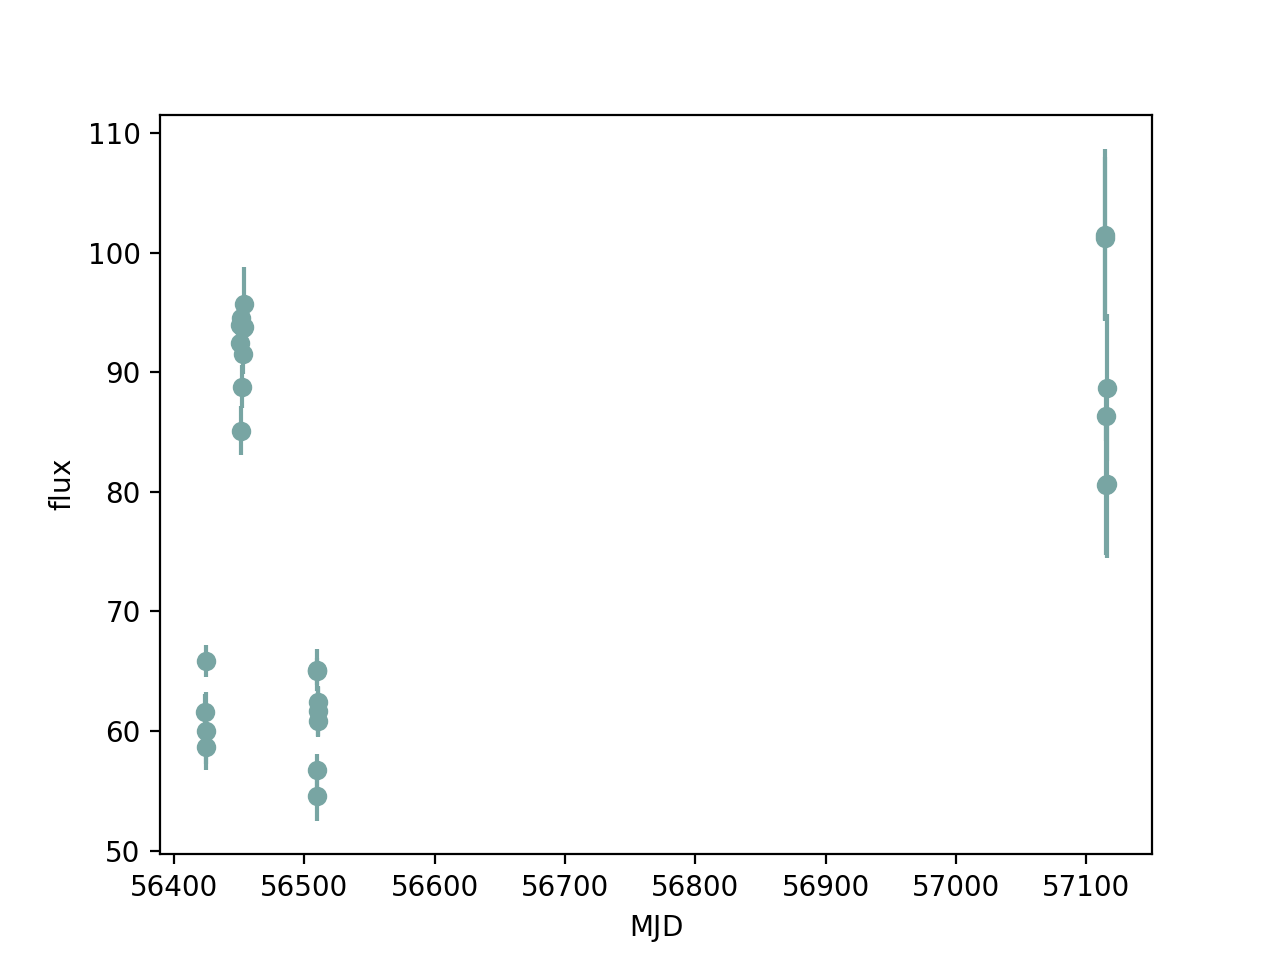

In [20]:
cur.execute("""select t, flux, dflux 
               from rawPhot
               where objId = 61 and pb = 'g'""")

data = cur.fetchall()
data = np.array(data)

fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], data[:,2], fmt = 'o', color = '#78A5A3')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")

Now that we have loaded the raw observations, we need to create a new table to store summary statistics for each object. This table will include everything we've added to the `ANTARESlc` class. 

In [21]:
cur.execute("""drop table if exists lcFeats""") # drop the table if it already exists
cur.execute("""create table lcFeats(
                id integer primary key,
                objId int,
                gStd float,
                rStd float,
                iStd float,
                zStd float,
                gAmp float, 
                rAmp float, 
                iAmp float, 
                zAmp float, 
                gMAD float,
                rMAD float,
                iMAD float,                
                zMAD float,                
                gBeyond float,
                rBeyond float,
                iBeyond float,
                zBeyond float,
                gSkew float,
                rSkew float,
                iSkew float,
                zSkew float,
                gMinusR float,
                rMinusI float,
                iMinusZ float,
                FOREIGN KEY(objId) REFERENCES rawPhot(objId)
                ) 
""")

The above procedure should look familiar to above, with one exception: the addition of the `foreign key` in the `lcFeats` table. The inclusion of the `foreign key` ensures a connected relationship between `rawPhot` and `lcFeats`. In brief, a row cannot be inserted into `lcFeats` unless a corresponding row, i.e. `objId`, exists in `rawPhot`. Additionally, rows in `rawPhot` cannot be deleted if there are dependent rows in `lcFeats`. 

**Problem 3d**

Calculate features for every source in `rawPhot` and insert those features into the `lcFeats` table. You'll first need a function to calculate the features.

In [22]:
# just like last time, we'll define a function to calculate the features for one lightcurve
# execute this

@require(ANTARESlc, 'pandas as pd', 'numpy as np', 'scipy.stats as spstat')
def calculate_features(filename):
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    lc.weighted_mean_flux()
    lc.normalized_flux_std()
    lc.normalized_amplitude()
    lc.normalized_MAD()
    lc.normalized_beyond_1std()
    lc.skew()
    lc.mean_colors()
    feats = (objId, lc.gStd, lc.rStd, lc.iStd, lc.zStd, 
            lc.gAmp,  lc.rAmp,  lc.iAmp,  lc.zAmp,  
            lc.gMAD, lc.rMAD, lc.iMAD, lc.zMAD, 
            lc.gBeyond, lc.rBeyond, lc.iBeyond, lc.zBeyond,
            lc.gSkew, lc.rSkew, lc.iSkew, lc.zSkew, 
            lc.gMinusR, lc.rMinusI, lc.iMinusZ)
    return feats

And again, map the function onto the filenames, and load the results into the table.

In [23]:
# and then lets map the function onto all the data
result = lview.map(calculate_features, filenames)

# and get the result
all_feats = result.get()

# and now load it all into our table
for feats in all_feats:
    cur.execute("""insert into lcFeats(objId, 
                                       gStd, rStd, iStd, zStd, 
                                       gAmp,  rAmp,  iAmp,  zAmp,  
                                       gMAD, rMAD, iMAD, zMAD, 
                                       gBeyond, rBeyond, iBeyond, zBeyond,
                                       gSkew, rSkew, iSkew, zSkew,
                                       gMinusR, rMinusI, iMinusZ) values {}""".format(feats))

**Problem 3e**

Confirm that the data loaded correctly by counting the number of sources with `gAmp` > 2.

How many sources have `gMinusR` = -999?

*Hint* - you should find 9 and 2, respectively.

In [24]:
cur.execute("""select count(*) from lcFeats where gAmp > 2""")

nAmp2 = cur.fetchone()[0]

cur.execute("""select count(*) from lcFeats where gMinusR = -999""")
nNoColor = cur.fetchone()[0]

print("There are {:d} sources with gAmp > 2".format(nAmp2))
print("There are {:d} sources with no measured i' - z' color".format(nNoColor))

There are 9 sources with gAmp > 2
There are 2 sources with no measured i' - z' color


Finally, we close by commiting the changes we made to the database.

Note that strictly speaking this is not needed, however, were we to update any values in the database then we would need to commit those changes.

In [25]:
conn.commit()

**mini Challenge Problem**

If there is less than 45 min to go, please skip this part. 

Earlier it was claimed that bulk loading the data is faster than loading it line by line. For this problem - prove this assertion, use `%%timeit` to "profile" the two different options (bulk load with `executemany` and loading one photometric measurement at a time via for loop).

Compare both serial solutions, to load the data in parallel.

*Hint* - to avoid corruption of your current working database, `miniANTARES.db`, create a new temporary database for the pupose of running this test. Also be careful with the names of your connection and cursor variables.

In [26]:
%%timeit
# bulk load solution

tmp_conn = sqlite3.connect("tmp1.db")
tmp_cur = tmp_conn.cursor()

tmp_cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
tmp_cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

for filename in filenames: 
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    data = [(objId,) + tuple(x) for x in lc.DFlc.values] # array of tuples

    tmp_cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

1 loop, best of 3: 789 ms per loop


In [27]:
%%timeit
# bulk load solution

tmp_conn = sqlite3.connect("tmp1.db")
tmp_cur = tmp_conn.cursor()

tmp_cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
tmp_cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

for filename in filenames: 
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    for obs in lc.DFlc.values:
        tmp_cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(obs)))

1 loop, best of 3: 1.6 s per loop


## Problem 4) Build a Classification Model

One of the primary goals for ANTARES is to separate the Wheat from the Chaff, in other words, given that ~10 million alerts will be issued by LSST on a nightly basis, what is the single (or 10, or 100) most interesting alert.

Here we will build on the skills developed during the DSFP Session 2 to construct a machine-learning model to classify new light curves. 

Fortunately - the data that has already been loaded to miniANTARES.db is a suitable training set for the classifier (we simply haven't provided you with labels just yet). Execute the cell below to add a new table to the database which includes the appropriate labels.

In [28]:
cur.execute("""drop table if exists lcLabels""") # drop the table if it already exists
cur.execute("""create table lcLabels(
               objId int,
               label int, 
               foreign key(objId) references rawPhot(objId)
               )""")

labels = np.zeros(100)
labels[20:60] = 1
labels[60:] = 2

data = np.append(np.arange(1,101)[np.newaxis].T, labels[np.newaxis].T, axis = 1)
tup_data = [tuple(x) for x in data]

cur.executemany("""insert into lcLabels(objId, label) values (?,?)""", tup_data)

For now - don't worry about what the labels mean (though if you inspect the light curves you may be able to figure this out...)

**Problem 4a**

Query the database to select features and labels for the light curves in your training set. Store the results of these queries in `numpy` arrays, `X` and `y`, respectively, which are suitable for the various `scikit-learn` machine learning algorithms.

*Hint* - recall that databases do not store ordered results.

*Hint 2* - recall that `scikit-learn` expects `y` to be a 1d array. You will likely need to convert a 2d array to 1d. 

In [29]:
cur.execute("""select label
               from lcLabels 
               order by objId asc""")
y = np.array(cur.fetchall()).ravel()

cur.execute("""select gStd, rStd, iStd, zStd, 
                      gAmp,  rAmp,  iAmp,  zAmp,  
                      gMAD, rMAD, iMAD, zMAD, 
                      gBeyond, rBeyond, iBeyond, zBeyond,
                      gSkew, rSkew, iSkew, zSkew,
                      gMinusR, rMinusI, iMinusZ
               from lcFeats
               order by objId asc""")
X = np.array(cur.fetchall())

**Problem 4b**

Train a SVM model ([`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) in `scikit-learn`) using a radial basis function (RBF) kernel with penalty parameter, $C = 1$, and kernel coefficient, $\gamma = 0.1$.

Evaluate the accuracy of the model via $k = 5$ fold cross validation. 

*Hint* - you may find the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) module helpful.

In [30]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

cv_scores = cross_val_score(SVC(C = 1.0, gamma = 0.1, kernel = 'rbf'), X, y, cv = 5)

print("The SVM model produces a CV accuracy of {:.4f}".format(np.mean(cv_scores)))

The SVM model produces a CV accuracy of 0.8600


/Users/gnarayan/anaconda2/envs/astroconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The SVM model does a decent job of classifying the data. However - we are going to have 10 million alerts every night. Therefore, we need something that runs quickly. For most ML models the training step is slow, while predictions (relatively) are fast. 

**Problem 4c**

Pick any other [classification model from `scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html), and "profile" the time it takes to train that model vs. the time it takes to train an SVM model.

Is the model that you have selected faster than SVM?

*Hint* - you should import the model outside your timing loop as we only care about the training step in this case.

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
svm_clf = SVC(C = 1.0, gamma = 0.1, kernel = 'rbf')

In [32]:
%%timeit
# timing solution for RF model
rf_clf.fit(X,y)

10 loops, best of 3: 39.1 ms per loop


In [33]:
%%timeit
# timing solution for SVM model
svm_clf.fit(X,y)

1000 loops, best of 3: 1.08 ms per loop


**Problem 4d**

Does the model you selected perform better than the SVM model? Perform a $k = 5$ fold cross validation to determine which model provides superior accuracy.

In [34]:
cv_scores = cross_val_score(RandomForestClassifier(), X, y, cv = 5)

print("The RF model produces a CV accuracy of {:.4f}".format(np.mean(cv_scores)))

The RF model produces a CV accuracy of 0.9000


**Problem 4e**

Which model are you going to use in your miniANTARES? Justify your answer. 

*Write solution to **4e** here*

In this case we are going to adopt the SVM model as it is a factor of 20 times faster than RF, while providing nearly identical performance from an accuracy stand point.

## Problem 5) Class Predictions for New Sources

Now that we have developed a basic infrastructure for dealing with streaming data, we may reap the rewards of our efforts. We will use our ANTARES-like software to classify newly observed sources.

**Problem 5a**

Load the light curves for the new observations (found in `full_testset_for_LSST_DSP`) into the a table in the database. 

*Hint* - ultimately it doesn't matter much one way or another, but you may choose to keep new observations in a table separate from the training data. I'm putting it into a new `testPhot` database. Up to you.

In [35]:
cur.execute("""drop table if exists testPhot""") # drop the table if is already exists
cur.execute("""create table testPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")
cur.execute("""drop table if exists testFeats""") # drop the table if it already exists
cur.execute("""create table testFeats(
                id integer primary key,
                objId int,
                gStd float,
                rStd float,
                iStd float,
                zStd float,
                gAmp float, 
                rAmp float, 
                iAmp float, 
                zAmp float, 
                gMAD float,
                rMAD float,
                iMAD float,                
                zMAD float,                
                gBeyond float,
                rBeyond float,
                iBeyond float,
                zBeyond float,
                gSkew float,
                rSkew float,
                iSkew float,
                zSkew float,
                gMinusR float,
                rMinusI float,
                iMinusZ float,
                FOREIGN KEY(objId) REFERENCES testPhot(objId)
                ) 
""")

In [36]:
new_obs_filenames = glob.glob("test_set_for_LSST_DSFP/FAKE*.dat")

result = lview.map(load_data, new_obs_filenames)
all_data = result.get()

In [37]:
for data in all_data: 
    cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 5b**

Calculate features for the new observations and insert those features into a database table.

*Hint* - again, you may want to create a new table for this, up to you. I'm using the `testFeats` table.

In [38]:
result = lview.map(calculate_features, new_obs_filenames)
all_feats = result.get()

In [39]:
for feats in all_feats: 
    cur.execute("""insert into testFeats(objId, 
                                       gStd, rStd, iStd, zStd, 
                                       gAmp,  rAmp,  iAmp,  zAmp,  
                                       gMAD, rMAD, iMAD, zMAD, 
                                       gBeyond, rBeyond, iBeyond, zBeyond,
                                       gSkew, rSkew, iSkew, zSkew,
                                       gMinusR, rMinusI, iMinusZ) values {}""".format(feats))

**Problem 5c**

Train the model that you adopted in **4e** on the training set, and produce predictions for the newly observed sources.

What is the class distribution for the newly detected sources?

*Hint* - the training set was constructed to have a nearly uniform class distribution, that may not be the case for the actual observed distribution of sources.

In [40]:
svm_clf = SVC(C=1.0, gamma = 0.1, kernel = 'rbf').fit(X, y)

cur.execute("""select gStd, rStd, iStd, zStd, 
                      gAmp,  rAmp,  iAmp,  zAmp,  
                      gMAD, rMAD, iMAD, zMAD, 
                      gBeyond, rBeyond, iBeyond, zBeyond,
                      gSkew, rSkew, iSkew, zSkew,
                      gMinusR, rMinusI, iMinusZ
               from testFeats
               order by objId asc""")
X_new = np.array(cur.fetchall())

y_preds = svm_clf.predict(X_new)

print("""There are {:d}, {:d}, and {:d} sources 
         in classes 1, 2, 3, respectively""".format(*list(np.bincount(y_preds)))) # be careful using bincount

There are 3276, 501, and 1223 sources 
         in classes 1, 2, 3, respectively


**Problem 5d**

This classification performance isn't great... Lets take a look at the actual class labels, since we sneakily left them in the file headers

In [41]:
 ! grep label test_set_for_LSST_DSFP/*dat | sed -e 's/label:/ /' | awk '{print $2+1}' | sort | uniq -c

3403 1
  90 2
1507 3


One thing you've probably noticed is that there are observations that have very large uncertainties, and out features (which are really just moments of the flux distribution) aren't really all that robust to outliers.

Let's try a more complex description of the shape of the light curves with a Gaussian process regression.
We'll need the `sklearn.gaussian_process` module

In [42]:
import sklearn.gaussian_process as gp

In [43]:
# we'll create a function that just fits the g band lightcurve
def calculate_gpfit(filename):
    """
    Do a quick gaussian process regression of just g-band lightcurve to get a smooth representation
    This should be more robust to outliers
    """
    lc = ANTARESlc(filename)
    t = lc.gtime.values
    y = lc.gFlux.values
    dy = lc.gFluxUnc.values
    t = t.reshape(-1, 1)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    
    # a Gaussian Process is defined by a correlation function that relates each point to each other
    # I've chosen a simple common kernel - the Matern kernel. 
    # It has a nice property in that it is 'stationary' - the covariance between points 
    # only depends on their separation
    
    base_kernel = gp.kernels.Matern(length_scale=10.,nu=2.5, length_scale_bounds=(1.,20.))
    gkernel = 0.5*(np.median(dy)**2.)*base_kernel
    
    # the second thing you need to define a Gaussian Process is a mean function, which in our case is 
    # implictly zero (this is fine for transients - they spend most of eternity at the background!)
    gband = gp.GaussianProcessRegressor(kernel=gkernel, alpha=dy**2.).fit(t, y)
    
    # now lets use the Gaussian process to predict the lightcurve on an evenly sampled grid
    # this is appropriate for Wavelets, or generally robust feature extraction
    
    newtime = np.linspace(t.min(), t.max(), 200, endpoint=True)
    newtime = newtime.reshape(-1, 1)
    gnew = gband.predict(newtime, return_cov=False)
    return (t, y , dy, newtime, gnew)

Lets look at one fit to see what's happening:

<IPython.core.display.Javascript object>


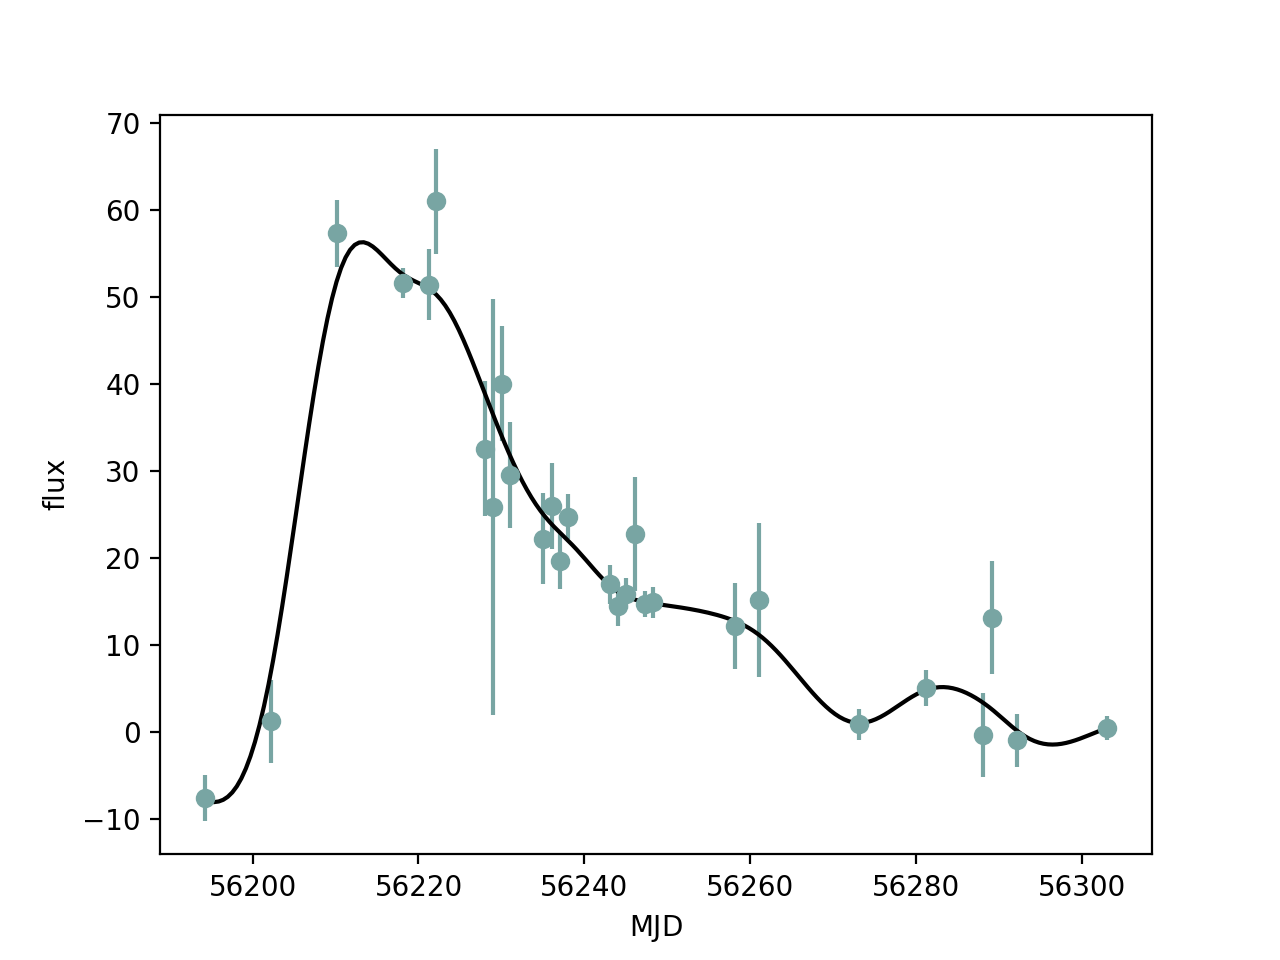

In [44]:
ftest = filenames[0:20]
gtime, gflux, gdflux, gnewtime, gnewflux = calculate_gpfit(ftest[3])

fig, ax = plt.subplots()
ax.errorbar(gtime, gflux, gdflux, fmt = 'o', color = '#78A5A3')
ax.plot(gnewtime, gnewflux, 'k-')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")

OH YAY! That's much better a more robust to noisy ratty data, the likes of which you will get all the darn time in astronomy!

Except, is this feasible to run?? Can we practically do it on 10^4--5 alerts every 37 seconds for `ANTARES`??

Well you have the tools to examine this! Let's profile the Gaussian Processes vs all the features

In [45]:
import cProfile
def dummy_func():
    
    all_fits = []
    all_feats = []
    for filename in ftest: 
        result  = calculate_gpfit(filename)
        result2 = calculate_features(filename)
        all_feats.append(result2)
        all_fits.append(result)
    
! rm -f gpstats.cprof    
cProfile.run('dummy_func()','gpstats.cprof')

Now let's see how long that took

In [46]:
%load_ext snakeviz
%snakeviz dummy_func()

 
*** Profile stats marshalled to file u'/var/folders/19/q2sxv35x6j107j2sf6k1jn900000gn/T/tmpcUiMTA'. 


Eeek. That's way slower than the regular feature computation!
It actually turns out that this is OK for us, because the implementation of Gaussian Process Regression in sklearn is pretty slow, and there are various better packages and approximations we can make to speed things up dramatically.

For the purposes of this exercise though, we'll stop here, since it's no fun to run these GPs on 5000 lightcurves (and our implementation isn't really robust either).

## Problem 6) Anomaly Detection

As we learned earlier - one of the primary goals of ANTARES is to reduce the stream of 10 million alerts on any given night to the single (or 10, or 100) most interesting objects. One possible definition of "interesting" is rarity - in which case it would be useful to add some form of anomaly detection to the pipeline. `scikit-learn` has [several different algorithms](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py) that can be used for anomaly detection. Here we will employ [isolation forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) which has many parallels to random forests, which we have previously learned about.

In brief, isolation forest builds an ensemble of decision trees where the splitting parameter in each node of the tree is selected randomly. In each tree the number of branches necessary to isolate each source is measured - outlier sources will, on average, require fewer splittings to be isolated than sources in high-density regions of the feature space. Averaging the number of branchings over many trees results in a relative ranking of the anomalousness (*yes, I just made up a word*) of each source.

**Problem 6a**

Using [`IsolationForest`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) in `sklearn.ensemble` - determine the 10 most isolated sources in the data set.

*Hint* - for `IsolationForest` you will want to use the `decision_function()` method rather than `predict_proba()`, which is what we have previously used with `sklearn.ensemble` models to get relative rankings from the model.

In [47]:
from sklearn.ensemble import IsolationForest

isoF_clf = IsolationForest(n_estimators = 100)
isoF_clf.fit(X_new)
anomaly_score = isoF_clf.decision_function(X_new)

print("The 10 most anomalous sources are: {}".format(np.arange(1,5001)[np.argsort(anomaly_score)[:10]]))

The 10 most anomalous sources are: [ 491  560 1706 2047 1592 3382  864 1733 2768 4146]


**Problem 6b**

Plot the light curves of the 2 most anomalous sources. 

Can you identify why these sources have been selected as outliers?

<IPython.core.display.Javascript object>


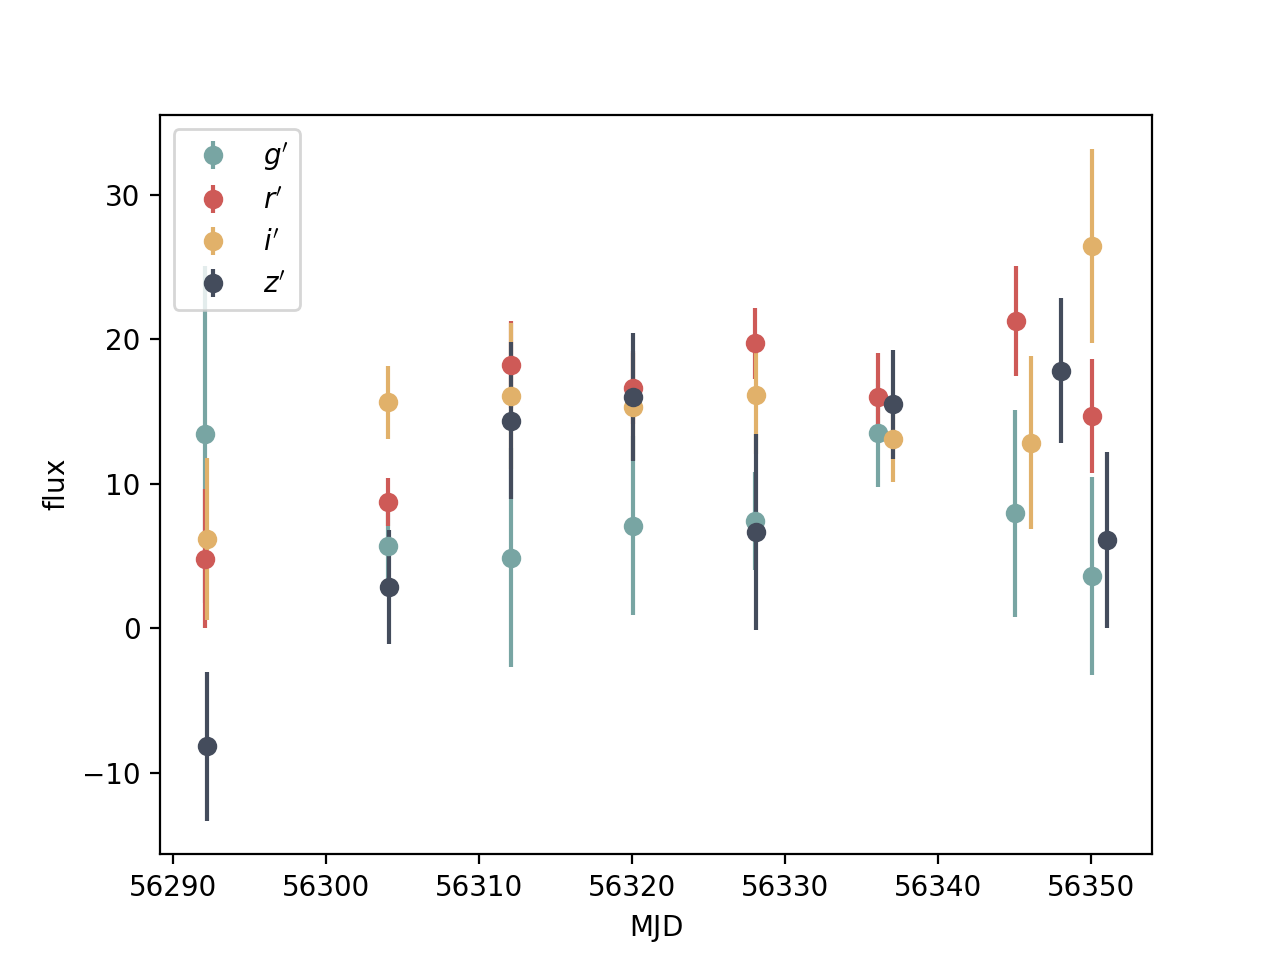

<IPython.core.display.Javascript object>


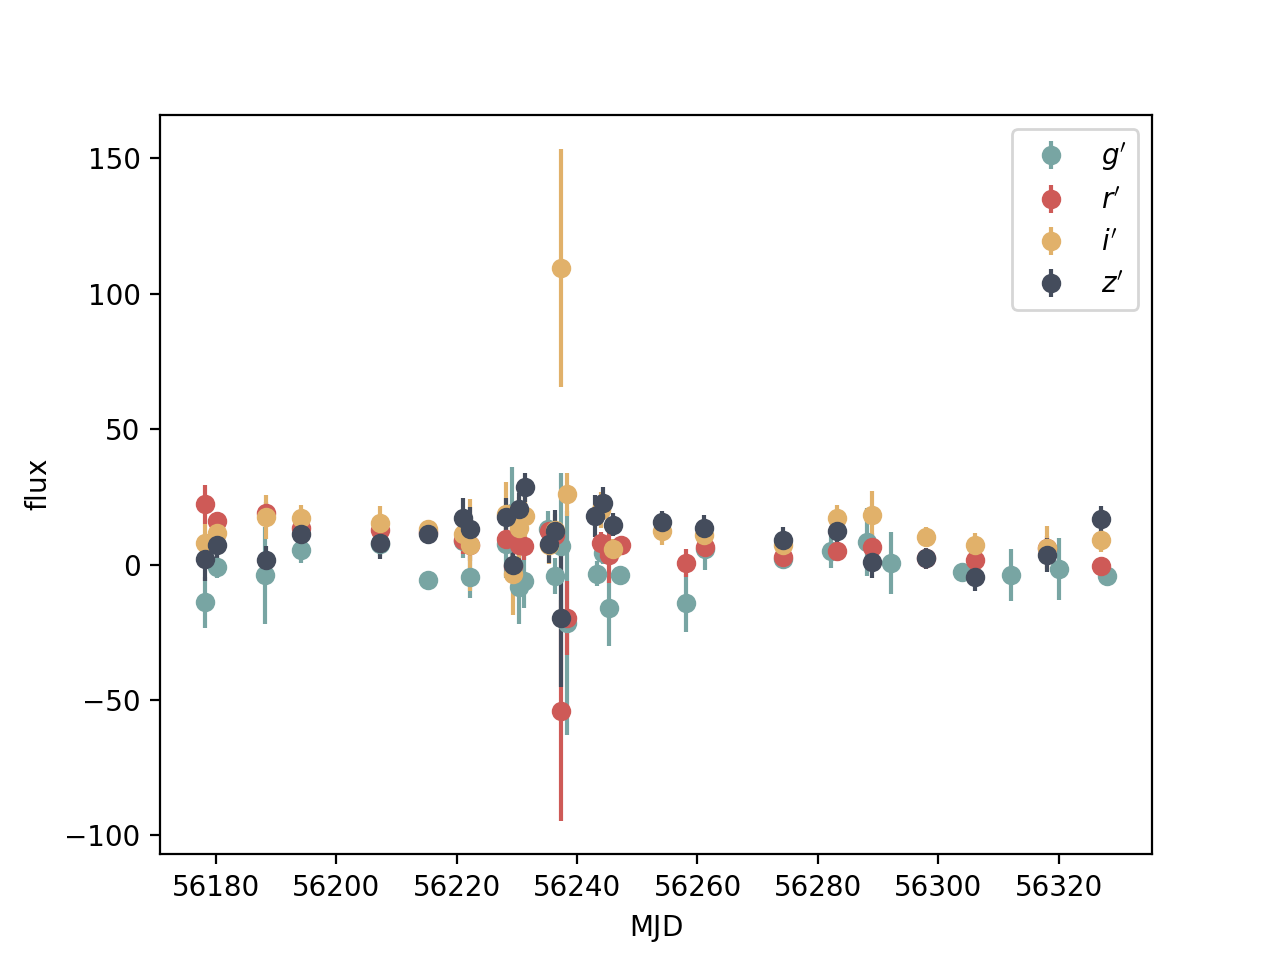

In [48]:
lc2030 = ANTARESlc("test_set_for_LSST_DSFP/FAKE02030.dat")
lc2030.plot_multicolor_lc()

lc491 = ANTARESlc("test_set_for_LSST_DSFP/FAKE00491.dat")
lc491.plot_multicolor_lc()

*Write solution to **6b** here*

For source 491 - this looks like a supernova at intermediate redshifts. What might be throwing it is the outlier point. We never really made our features very robust to outliers.

For source 2030 - This is a weird faint source with multiple unsynced rises and falls in different bands.

## Challenge Problem) Simulate a Real ANTARES

The problem that we just completed features a key difference from the true ANTARES system - namely, all the light curves analyzed had a complete set of observations loaded into the database. One of the key challenges for LSST (and by extension ANTARES) is that the data will be *streaming* - new observations will be available every night, but the full light curves for all sources won't be available until the 10 yr survey is complete. In this problem, you will use the same data to simulate an LSST-like classification problem.

Assume that your training set (i.e. the first 100 sources loaded into the database) were observed prior to LSST, thus, these light curves can still be used in their entirety to train your classification models. For the test set of observations, simulate LSST by determining the min and max observation date and take 1-d quantized steps through these light curves. On each day when there are new observations, update the feature calculations for every source that has been newly observed. Classify those sources and identify possible anomalies.

Here are some things you should think about as you build this software:

1. Should you use the entire light curves for training-set objects when classifying sources with only a few data points?
2. How are you going to handle objects on the first epoch when they are detected?
3. What threshold (if any) are you going to set to notify the community about rarities that you have discovered

*Hint* - Since you will be reading these light curves from the database (and not from text files) the `ANTARESlc` class that we previously developed will not be useful. You will (likely) either need to re-write this class to interact with the database or figure out how to massage the query results to comply with the class definitions.